In [1]:

import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
import numpy as np
from src.data.dataset import COVID19Dataset, DataLoaderFactory
from src.data.preprocessing import DataAugmentation




In [2]:

# Cell 2: Configuration
TRAIN_DIR = '../data/processed/train'
VAL_DIR = '../data/processed/val'
TEST_DIR = '../data/processed/test'

BATCH_SIZE = 16
NUM_WORKERS = 2



In [3]:
# Cell 3: Create DataLoaders
print("Creating DataLoaders...")

train_transform = DataAugmentation.get_train_transform()
val_transform = DataAugmentation.get_val_transform()

train_loader, val_loader, test_loader, class_names = DataLoaderFactory.create_dataloaders(
    TRAIN_DIR,
    VAL_DIR,
    TEST_DIR,
    train_transform,
    val_transform,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    use_weighted_sampling=True
)

print(f"\n✅ Class names: {class_names}")


Creating DataLoaders...
Creating datasets...
✅ Loaded 14814 images from 4 classes

Class Distribution in ../data/processed/train:
--------------------------------------------------
  COVID                :  2531 (17.09%)
  Lung_Opacity         :  4208 (28.41%)
  Normal               :  7134 (48.16%)
  Viral Pneumonia      :   941 ( 6.35%)
--------------------------------------------------
✅ Loaded 3175 images from 4 classes

Class Distribution in ../data/processed/val:
--------------------------------------------------
  COVID                :   542 (17.07%)
  Lung_Opacity         :   902 (28.41%)
  Normal               :  1529 (48.16%)
  Viral Pneumonia      :   202 ( 6.36%)
--------------------------------------------------
✅ Loaded 3176 images from 4 classes

Class Distribution in ../data/processed/test:
--------------------------------------------------
  COVID                :   543 (17.10%)
  Lung_Opacity         :   902 (28.40%)
  Normal               :  1529 (48.14%)
  Viral Pn

Batch shape: torch.Size([16, 3, 224, 224])
Labels: tensor([2, 0, 3, 3, 1, 2, 0, 2, 2, 3, 2, 2, 0, 3, 0, 3])


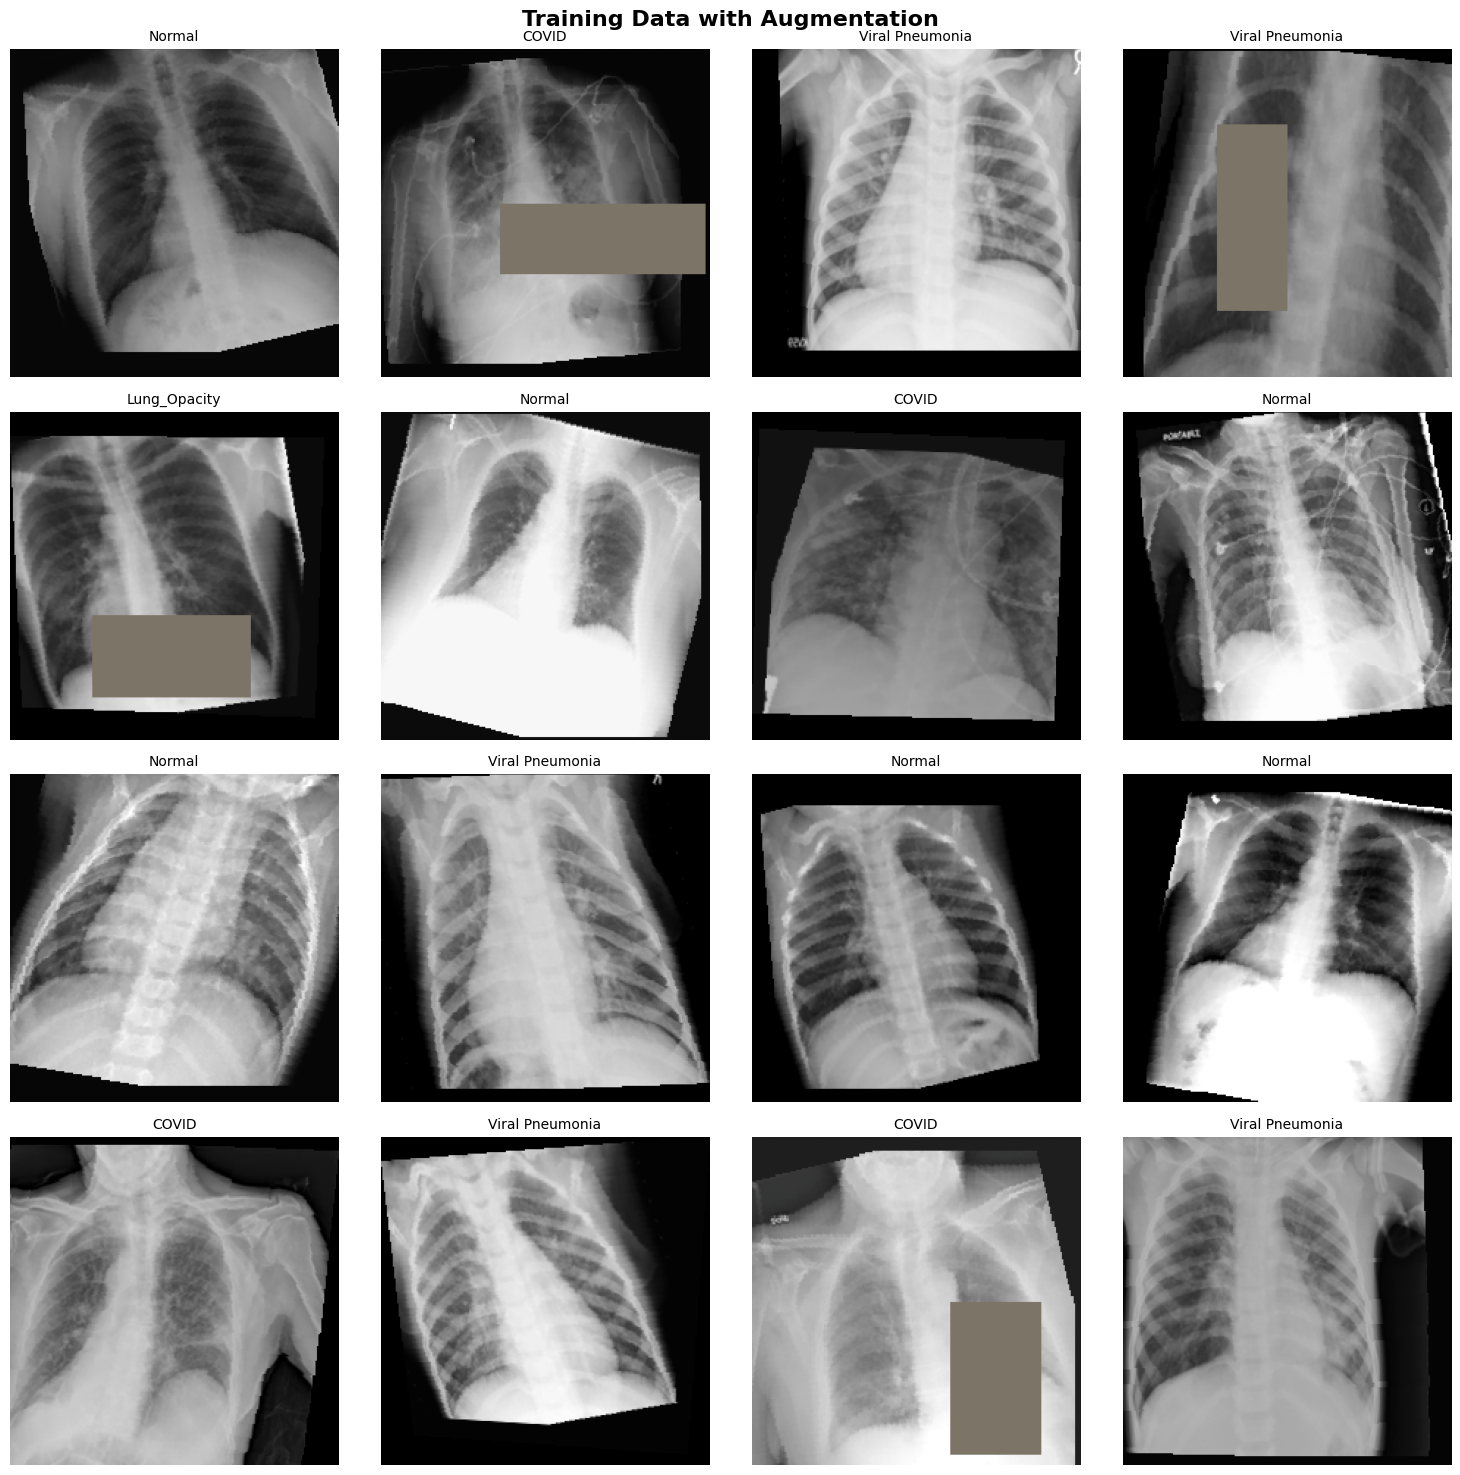

In [4]:

# Cell 4: Visualize augmented samples
def denormalize(tensor):
    """Denormalize images for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

def show_batch(images, labels, class_names, title="Batch Visualization"):
    """Visualize a batch of images"""
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for idx in range(min(16, len(images))):
        row = idx // 4
        col = idx % 4
        
        # Denormalize and convert to numpy
        img = denormalize(images[idx]).cpu()
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        # Plot
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{class_names[labels[idx]]}", fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    return fig

# Get a batch from training set
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels: {labels}")

# Visualize
fig = show_batch(images, labels, class_names, "Training Data with Augmentation")
plt.savefig('../results/plots/augmented_batch.png', dpi=300, bbox_inches='tight')
plt.show()


In [5]:

# Cell 5: Check class distribution in batches
def check_batch_distribution(loader, num_batches=10):
    """Check class distribution across batches"""
    all_labels = []
    
    for i, (_, labels) in enumerate(loader):
        if i >= num_batches:
            break
        all_labels.extend(labels.numpy())
    
    # Count occurrences
    from collections import Counter
    label_counts = Counter(all_labels)
    
    print(f"\nClass distribution across {num_batches} batches:")
    print("-" * 50)
    for idx, cls in enumerate(class_names):
        count = label_counts.get(idx, 0)
        print(f"{cls:20} : {count:3} samples")
    print("-" * 50)

check_batch_distribution(train_loader, num_batches=10)



Class distribution across 10 batches:
--------------------------------------------------
COVID                :  35 samples
Lung_Opacity         :  36 samples
Normal               :  45 samples
Viral Pneumonia      :  44 samples
--------------------------------------------------


✅ Loaded 14814 images from 4 classes

Class Distribution in ../data/processed/train:
--------------------------------------------------
  COVID                :  2531 (17.09%)
  Lung_Opacity         :  4208 (28.41%)
  Normal               :  7134 (48.16%)
  Viral Pneumonia      :   941 ( 6.35%)
--------------------------------------------------


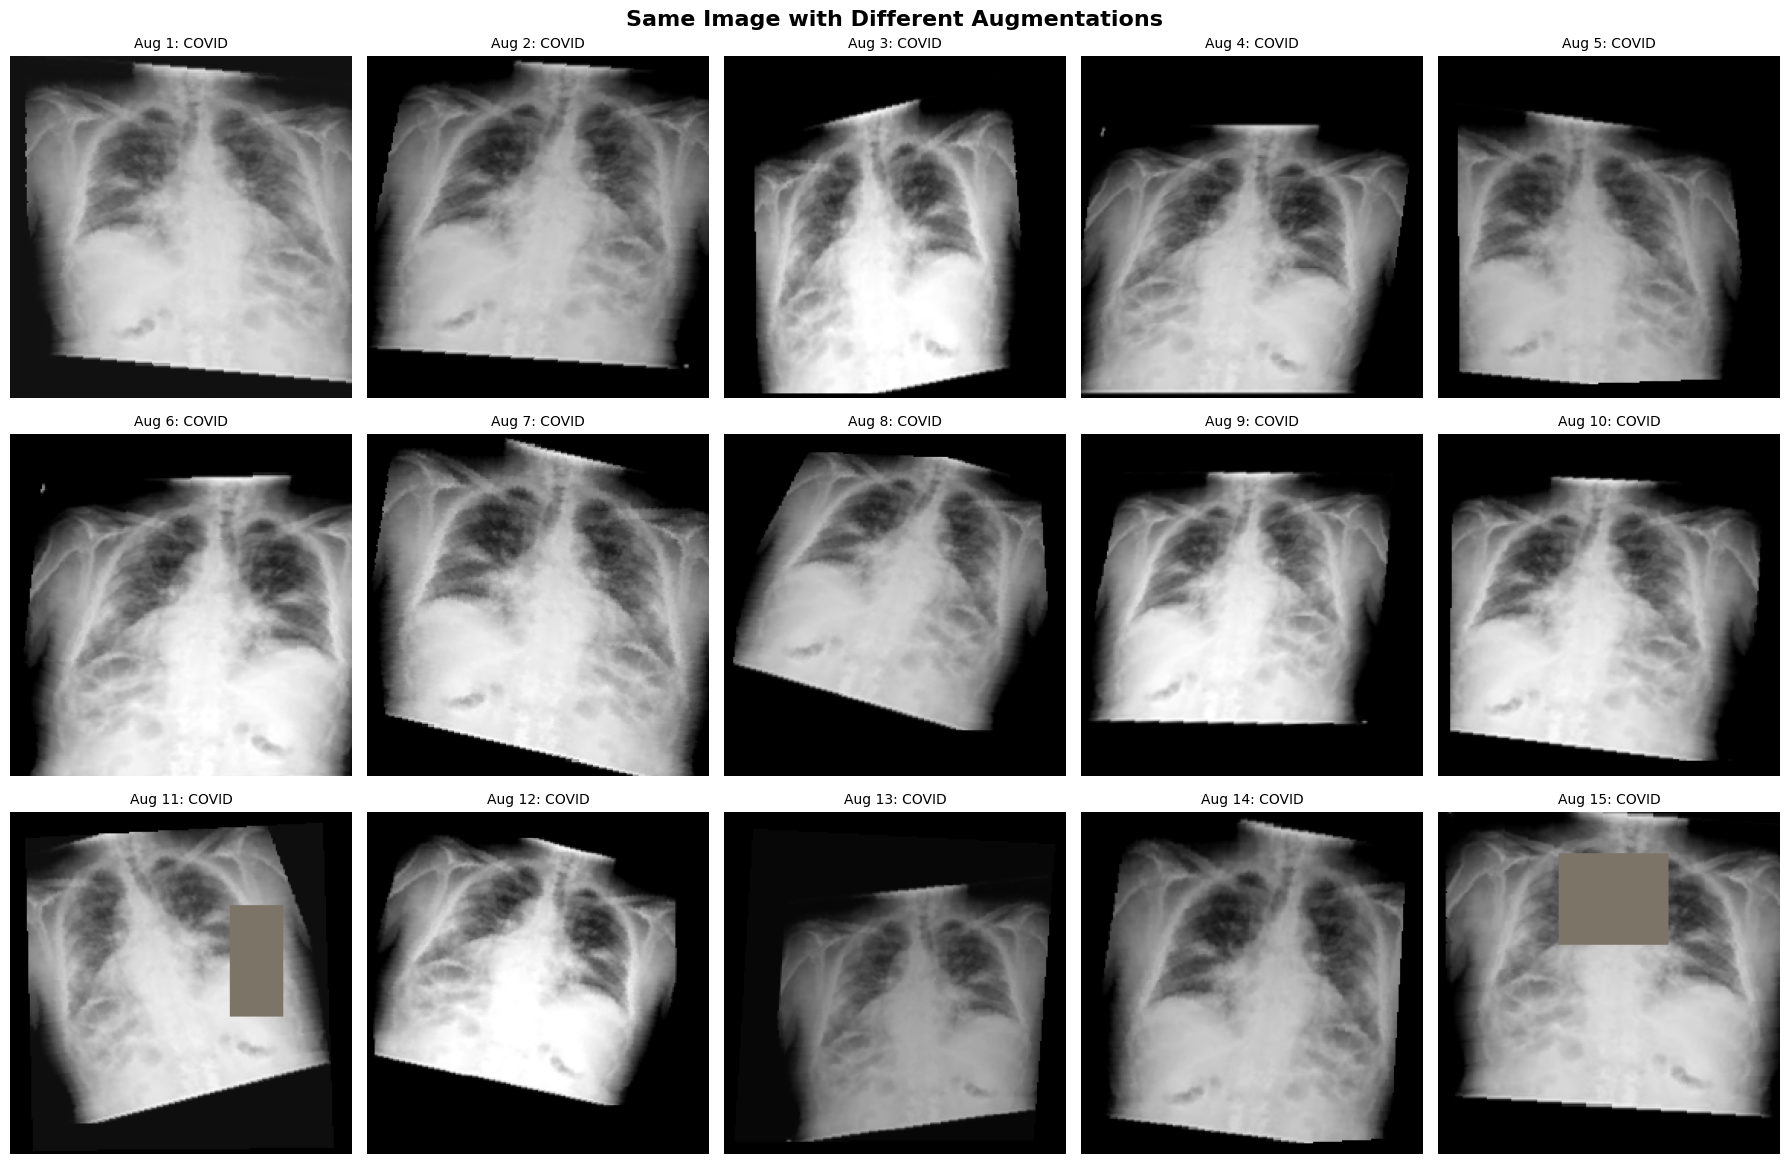

In [6]:

# Cell 6: Compare original vs augmented
# Load same image multiple times to see augmentation variations
train_dataset = COVID19Dataset(TRAIN_DIR, transform=train_transform)

# Get one sample
sample_idx = 100
fig, axes = plt.subplots(3, 5, figsize=(18, 12))
fig.suptitle("Same Image with Different Augmentations", fontsize=16, fontweight='bold')

for i in range(15):
    row = i // 5
    col = i % 5
    
    img, label = train_dataset[sample_idx]
    img = denormalize(img)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    axes[row, col].imshow(img)
    axes[row, col].set_title(f"Aug {i+1}: {class_names[label]}", fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('../results/plots/augmentation_variations.png', dpi=300, bbox_inches='tight')
plt.show()



In [8]:
# Cell 7: Check tensor properties
print("\nTensor Properties:")
print("-" * 50)
print(f"Batch shape: {images.shape}")
print(f"Data type: {images.dtype}")
print(f"Min value: {images.min():.3f}")
print(f"Max value: {images.max():.3f}")
print(f"Mean: {images.mean():.3f}")
print(f"Std: {images.std():.3f}")
print("-" * 50)




Tensor Properties:
--------------------------------------------------
Batch shape: torch.Size([16, 3, 224, 224])
Data type: torch.float32
Min value: -2.118
Max value: 2.640
Mean: -0.043
Std: 1.333
--------------------------------------------------


In [9]:
# Cell 8: Memory usage estimate
def estimate_memory_usage(loader, num_epochs=50):
    """Estimate memory requirements"""
    batch = next(iter(loader))
    images, labels = batch
    
    # Size per batch (in MB)
    batch_size_mb = (images.element_size() * images.nelement()) / (1024 ** 2)
    
    # Total for one epoch
    epoch_size_mb = batch_size_mb * len(loader)
    
    # Total for training
    total_size_mb = epoch_size_mb * num_epochs
    
    print(f"\nMemory Usage Estimate:")
    print("-" * 50)
    print(f"Batch size (MB): {batch_size_mb:.2f}")
    print(f"Per epoch (MB): {epoch_size_mb:.2f}")
    print(f"For {num_epochs} epochs (MB): {total_size_mb:.2f}")
    print(f"For {num_epochs} epochs (GB): {total_size_mb/1024:.2f}")
    print("-" * 50)



In [10]:
estimate_memory_usage(train_loader)

# Cell 9: Summary
print("\n" + "="*70)
print("PREPROCESSING PIPELINE SUMMARY")
print("="*70)
print(f"""
✅ Data split into train/val/test
✅ Augmentation pipeline created
✅ Custom Dataset class working
✅ DataLoaders created with weighted sampling
✅ Visualizations generated

📊 Dataset Statistics:
   - Classes: {len(class_names)}
   - Train batches: {len(train_loader)}
   - Val batches: {len(val_loader)}
   - Test batches: {len(test_loader)}
   - Batch size: {BATCH_SIZE}
""")
print("="*70)


Memory Usage Estimate:
--------------------------------------------------
Batch size (MB): 9.19
Per epoch (MB): 8507.62
For 50 epochs (MB): 425381.25
For 50 epochs (GB): 415.41
--------------------------------------------------

PREPROCESSING PIPELINE SUMMARY

✅ Data split into train/val/test
✅ Augmentation pipeline created
✅ Custom Dataset class working
✅ DataLoaders created with weighted sampling
✅ Visualizations generated

📊 Dataset Statistics:
   - Classes: 4
   - Train batches: 926
   - Val batches: 199
   - Test batches: 199
   - Batch size: 16

